In [ ]:
# import libraries

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))

# pytorch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# sklearn
from sklearn.metrics import classification_report

# utils
import os
import random
from tqdm import tqdm
tqdm.pandas()
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


positive    12517
negative    12483
Name: sentiment, dtype: int64


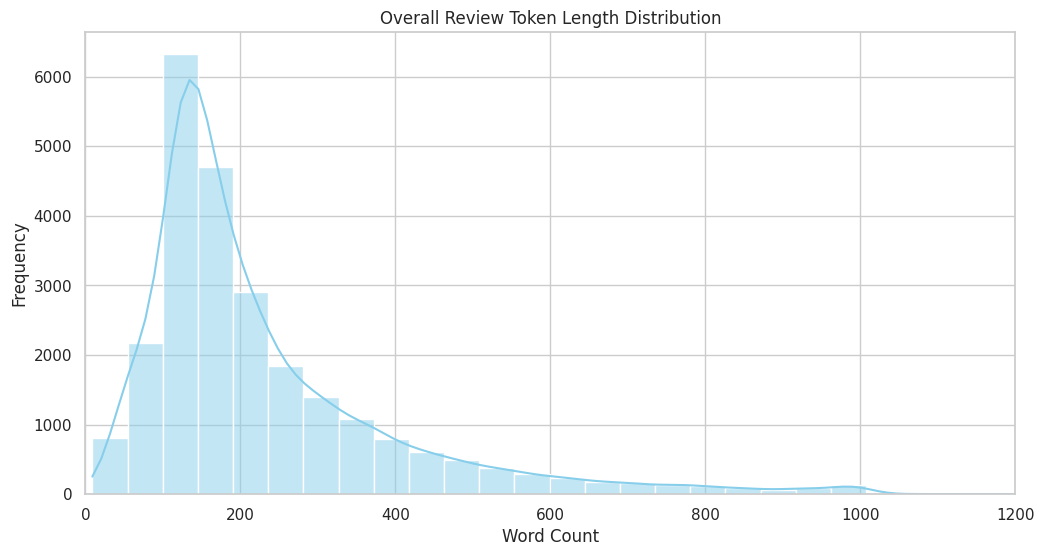

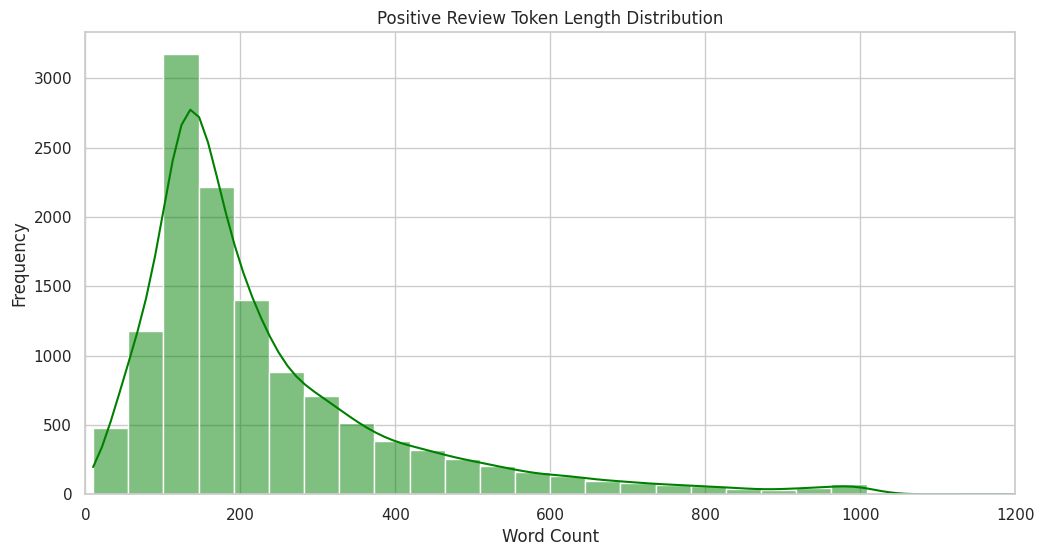

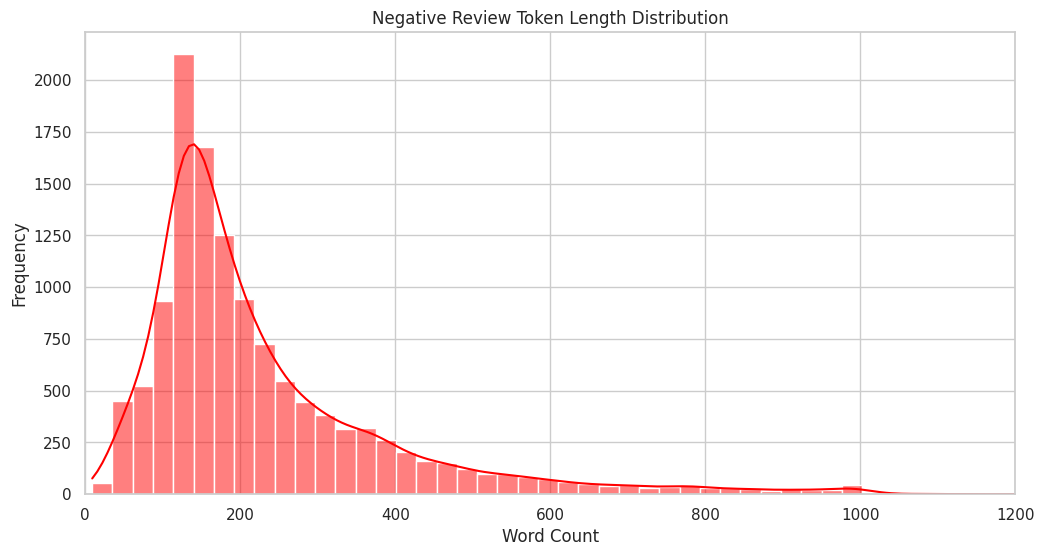

In [ ]:
#load a datataset from ./IMDB Dataset.csv
imdb_data = pd.read_csv('/content/drive/MyDrive/IMDB_Dataset.csv')


# Take only 50% of the dataset
imdb_data = imdb_data.sample(frac=0.5, random_state=42)

# Create a binary label column
imdb_data['label'] = (imdb_data['sentiment'] == 'positive').astype(int)

# Check balance of dataset
print(imdb_data['sentiment'].value_counts())

# Check word count of each review
imdb_data['word_count'] = imdb_data['review'].apply(lambda x: len(x.split()))

# Set styling as seaborn for convenience
sns.set(style='whitegrid')

# Plot word count distributions
plt.figure(figsize=(12, 6))

# Overall review word count distribution
sns.histplot(imdb_data['word_count'], bins=50, kde=True, color='skyblue')
plt.title('Overall Review Token Length Distribution')
plt.xlim(0,1200)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Positive review word count distribution
plt.figure(figsize=(12, 6))
sns.histplot(imdb_data[imdb_data['label'] == 1]['word_count'], bins=50, kde=True, color='green')
plt.title('Positive Review Token Length Distribution')
plt.xlim(0,1200)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Negative review word count distribution
plt.figure(figsize=(12, 6))
sns.histplot(imdb_data[imdb_data['label'] == 0]['word_count'], bins=50, kde=True, color='red')
plt.title('Negative Review Token Length Distribution')
plt.xlim(0,1200)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()




In [ ]:
# text cleaning

def clean_text(text):
    # Remove links and HTML tags
    text = re.sub(r'https?://\S+|www\.\S+|<[^>]+>', '', text)

    # Remove non-ASCII characters, emojis, and extra whitespaces
    text = re.sub(r'[^\x00-\x7f]|['
                  u'\U0001F600-\U0001F64F'
                  u'\U0001F300-\U0001F5FF'
                  u'\U0001F680-\U0001F6FF'
                  u'\U0001F1E0-\U0001F1FF'
                  u'\U00002702-\U000027B0'
                  u'\U000024C2-\U0001F251'
                  ']+', '', text)

    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces

    # Correct repeated characters (e.g., loooove -> love)
    text = re.sub(r'(.)\1+', r'\1\1', text)

    return text

def preprocess_text(text):
    # Tokenize and remove stopwords
    tokens = [word for word in word_tokenize(text) if word.lower() not in stopwords]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(lemmas)

# Assuming you have 'imdb_data' DataFrame with a 'review' column
imdb_data['cleaned'] = imdb_data['review'].progress_apply(clean_text)
imdb_data['processed'] = imdb_data['cleaned'].progress_apply(preprocess_text)

# Keep only the 'processed' and 'label' columns
imdb_data[['processed', 'label']].to_csv('./imdb_processed.csv', index=False, header=True)



100%|██████████| 25000/25000 [00:58<00:00, 426.18it/s]


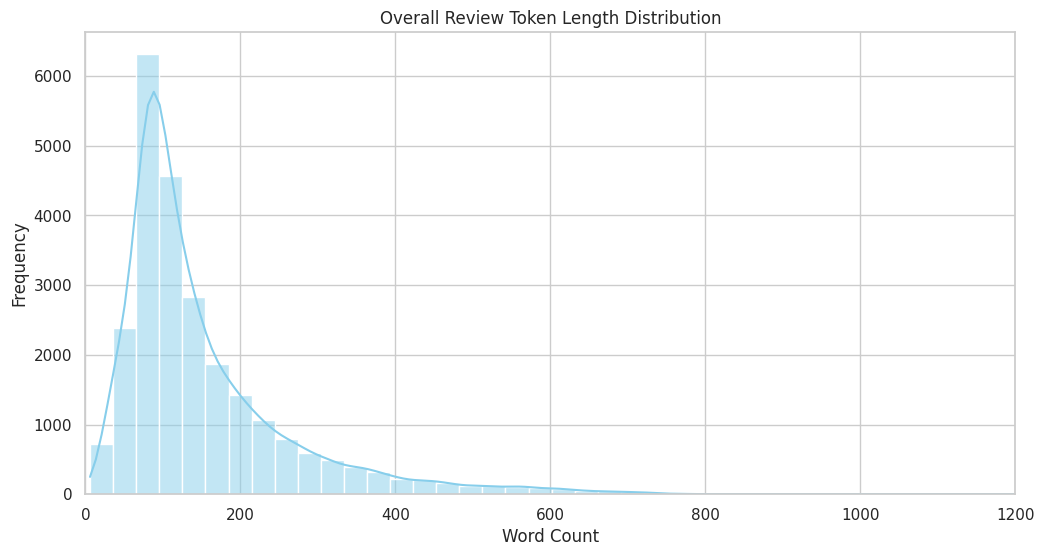

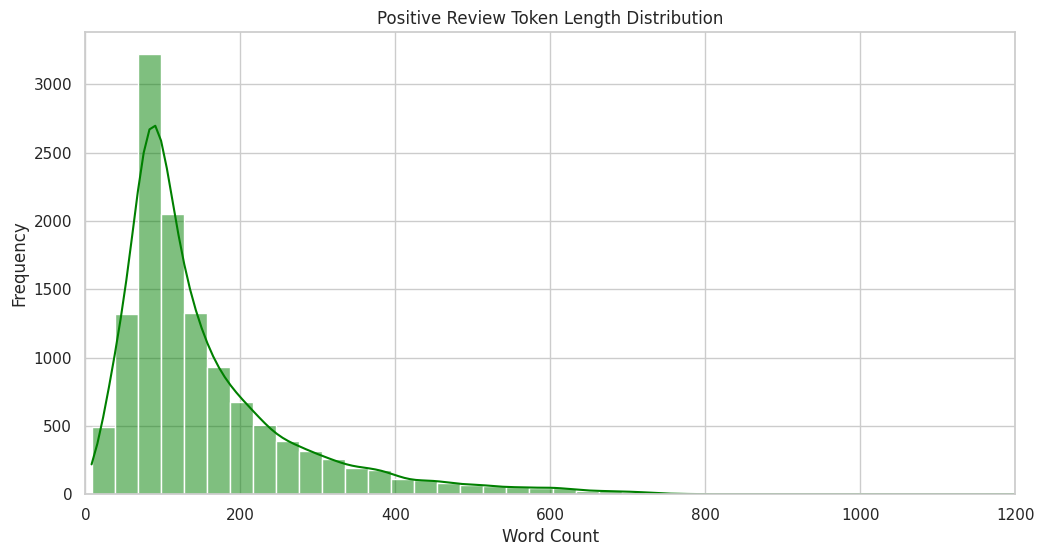

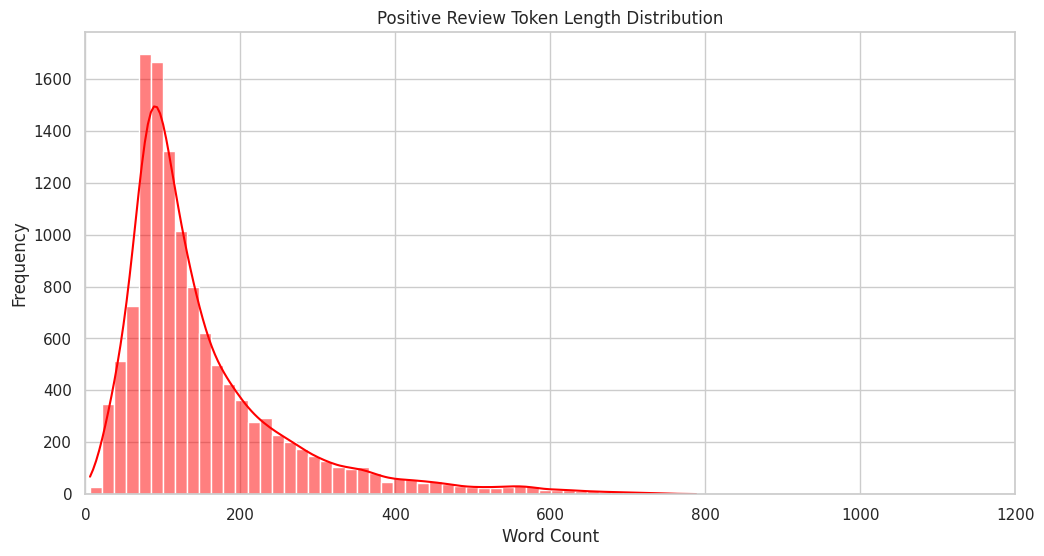

In [ ]:

sns.set(style='whitegrid')

plt.figure(figsize=(12, 6))

# Overall review word count distribution
sns.histplot(imdb_data['processed'].apply(lambda x: len(x.split())), bins=50, kde=True, color='skyblue')
plt.title('Overall Review Token Length Distribution')
plt.xlim(0,1200)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(12, 6))
sns.histplot(imdb_data[imdb_data['label'] == 1]['processed'].apply(lambda x: len(x.split())), bins=50, kde=True, color='green')
plt.title('Positive Review Token Length Distribution')
plt.xlim(0,1200)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(12, 6))
sns.histplot(imdb_data[imdb_data['label'] == 0]['processed'].apply(lambda x: len(x.split())), bins=50, kde=True, color='red')
plt.title('Positive Review Token Length Distribution')
plt.xlim(0,1200)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
data = pd.read_csv('./imdb_processed.csv')

for _, row in data.head(2).iterrows():
    print(row['processed'])
    print(f'Label: {row["label"]}\n')

reviews = data.processed.values
words = ' '.join(reviews)
words = words.split()

print(words[:10])

counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}

reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

for i in range(5):
    print(reviews_enc[i][:5])

def pad_features(reviews, pad_id, seq_length):
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length_100 = 100
seq_length_200 = 200

features_100 = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length_100)
features_200 = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length_200)

assert len(features_100) == len(reviews_enc)
assert len(features_100[0]) == seq_length_100

assert len(features_200) == len(reviews_enc)
assert len(features_200[0]) == seq_length_200

print(features_100[:10, :10])
print(features_200[:10, :10])

labels = data.label.to_numpy()


really liked Summerslam due look arena , curtain look overall interesting reason . Anyways , could one best Summerslam 's ever WWF n't Lex Luger main event Yokozuna , 's time ok huge fat man v strong man 'm glad time changed . terrible main event like every match Luger terrible . match card Razor Ramon v Ted Dibiase , Steiner Brothers v Heavenly Bodies , Shawn Michaels v Curt Hening , event Shawn named big monster body guard Diesel , IRS v 1-2-3 Kid , Bret Hart first take Doink take Jerry Lawler stuff Harts Lawler always interesting , Ludvig Borga destroyed Marty Jannetty , Undertaker took Giant Gonzalez another terrible match , Smoking Gunns Tatanka took Bam Bam Bigelow Headshrinkers , Yokozuna defended world title Lex Luger match boring terrible ending . However deserves 8/10
Label: 1

many television show appeal quite many different kind fan like Farscape .. know youngster 30/40+ year old ; fan Male Female many different country think adore T.V miniseries . element found almost ever

100%|██████████| 25000/25000 [00:00<00:00, 27759.86it/s]


[24, 328, 32122, 551, 57]
[51, 556, 35, 1009, 102]
[5, 734, 20, 578, 963]
[960, 2831, 19, 356, 12594]
[23769, 503, 267, 308, 22]
[[   24   328 32122   551    57 14002     1  6922    57   639]
 [   51   556    35  1009   102    51   187   141   119    13]
 [    5   734    20   578   963    26    62  7786  3360     2]
 [  960  2831    19   356 12594    11    12  7788  5487  1154]
 [23769   503   267   308    22     4     1   103  1192  4968]
 [   67   192     4   814  1587  2738    43     1    56    20]
 [   21   292  9799  1299   459  1569   241     2 32127 11521]
 [ 1551     1     9    20 15830    38    40    15   192   184]
 [  550   138     2    78   510  1223     3     2   423   652]
 [   40   857   105 19510  2306 37038  2768     1 19511   296]]
[[   24   328 32122   551    57 14002     1  6922    57   639]
 [   51   556    35  1009   102    51   187   141   119    13]
 [    5   734    20   578   963    26    62  7786  3360     2]
 [  960  2831    19   356 12594    11    12  7788  

In [ ]:
seq_lengths = [100, 200]

test_size = 0.2
features = [pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length) for seq_length in seq_lengths]
train_test_splits = [train_test_split(feature, labels, test_size=test_size, random_state=2) for feature in features]

print('Feature Shapes:')
print('===============')
for seq_length, (X_train, X_test, Y_train, Y_test) in zip(seq_lengths, train_test_splits):
    print(f'Train set ({seq_length}): {X_train.shape}')
    print(f'Test set ({seq_length}): {X_test.shape}')

batch_size = 400

trainsets = [TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train)) for X_train, _, Y_train, _ in train_test_splits]
testsets = [TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test)) for _, X_test, _, Y_test in train_test_splits]

train_loaders = [DataLoader(trainset, shuffle=True, batch_size=batch_size) for trainset in trainsets]
test_loaders = [DataLoader(testset, shuffle=False, batch_size=batch_size) for testset in testsets]



Feature Shapes:
Train set (100): (20000, 100)
Test set (100): (5000, 100)
Train set (200): (20000, 200)
Test set (200): (5000, 200)


In [ ]:
class SentimentBaseModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size, embedding_size, n_layers, rnn_type):
        super(SentimentBaseModel, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        # Create RNN layer based on the specified type
        rnn_types = {'LSTM': nn.LSTM, 'RNN': nn.RNN}
        if rnn_type not in rnn_types:
            raise ValueError("Invalid RNN type. Supported types: 'LSTM' or 'RNN'.")
        self.rnn = rnn_types[rnn_type](embedding_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        x = x.long()
        x = self.embedding(x)
        o, hidden = self.rnn(x, hidden)
        o = o[:, -1, :]
        o = self.fc(o)
        o = self.sigmoid(o)

        return o, hidden

    def initHidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size), torch.zeros(self.n_layers, batch_size, self.hidden_size)

class SentimentLSTMModel(SentimentBaseModel):
    def __init__(self, vocab_size, output_size, hidden_size, embedding_size, n_layers):
        super(SentimentLSTMModel, self).__init__(vocab_size, output_size, hidden_size, embedding_size, n_layers, 'LSTM')

    def initHidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size), torch.zeros(self.n_layers, batch_size, self.hidden_size)

class SentimentRNNModel(SentimentBaseModel):
    def __init__(self, vocab_size, output_size, hidden_size, embedding_size, n_layers):
        super(SentimentRNNModel, self).__init__(vocab_size, output_size, hidden_size, embedding_size, n_layers, 'RNN')

    def initHidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size)

In [ ]:
hidden_sizes = [32, 16]

vocab_size = len(word2int)
output_size = 1
embedding_sizes = [100, 200]
n_layers = 2
epochs = 10

loss_fn = nn.BCELoss()

models_with_optims = []
for hidden_size in hidden_sizes:
    for embedding_size in embedding_sizes:
        model = SentimentLSTMModel(vocab_size, output_size, hidden_size, embedding_size, n_layers)
        model2 = SentimentRNNModel(vocab_size, output_size, hidden_size, embedding_size, n_layers)

        optimizer = Adam(model.parameters())
        optimizer2 = Adam(model2.parameters())

        models_with_optims.append((model, optimizer, f'LSTM (hidden_size={hidden_size}, embedding_size={embedding_size})'))
        models_with_optims.append((model2, optimizer2, f'RNN (hidden_size={hidden_size}, embedding_size={embedding_size})'))


losses_over_epochs = defaultdict(list)

def train(model, optimizer, information_str, trainloader, testloader, epochs):
    print(information_str)
    model.train()
    for epoch in range(epochs):
        for (inputs, labels) in trainloader:
            optimizer.zero_grad()
            batch_size = inputs.size(0)
            hidden = model.initHidden(batch_size)
            output, hidden = model(inputs, hidden)
            loss = loss_fn(output.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            losses_over_epochs[information_str].append(loss.item())
        print(f"Epoch: {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = []
        y_true = []
        for (inputs, labels) in testloader:
            batch_size = inputs.size(0)
            hidden = model.initHidden(batch_size)
            output, hidden = model(inputs, hidden)
            y_pred.extend(output.squeeze().tolist())
            y_true.extend(labels.tolist())
        report = classification_report(y_true, np.array(y_pred) > 0.5, target_names=['Negative', 'Positive'])
        print(f'\nClassification Report:\n{report}')

    print('-' * 100)
    return model

for index, (model, optimizer, information_str) in enumerate(models_with_optims):
    training_loader = train_loaders[(index % 4) // 2]
    test_loader = test_loaders[(index % 4) // 2]
    train(model, optimizer, information_str, training_loader, test_loader, epochs)

LSTM (hidden_size=32, embedding_size=100)
Epoch: 1/10, Loss: 0.6919
Epoch: 2/10, Loss: 0.6619
Epoch: 3/10, Loss: 0.6795
Epoch: 4/10, Loss: 0.6717
Epoch: 5/10, Loss: 0.5547
Epoch: 6/10, Loss: 0.4211
Epoch: 7/10, Loss: 0.4618
Epoch: 8/10, Loss: 0.3409
Epoch: 9/10, Loss: 0.3517
Epoch: 10/10, Loss: 0.2926

Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.78      0.77      2553
    Positive       0.76      0.74      0.75      2447

    accuracy                           0.76      5000
   macro avg       0.76      0.76      0.76      5000
weighted avg       0.76      0.76      0.76      5000

----------------------------------------------------------------------------------------------------
RNN (hidden_size=32, embedding_size=100)
Epoch: 1/10, Loss: 0.6914
Epoch: 2/10, Loss: 0.6893
Epoch: 3/10, Loss: 0.6796
Epoch: 4/10, Loss: 0.6796
Epoch: 5/10, Loss: 0.6058
Epoch: 6/10, Loss: 0.5860
Epoch: 7/10, Loss: 0.5358
Epoch: 8/10, Loss: 0.6

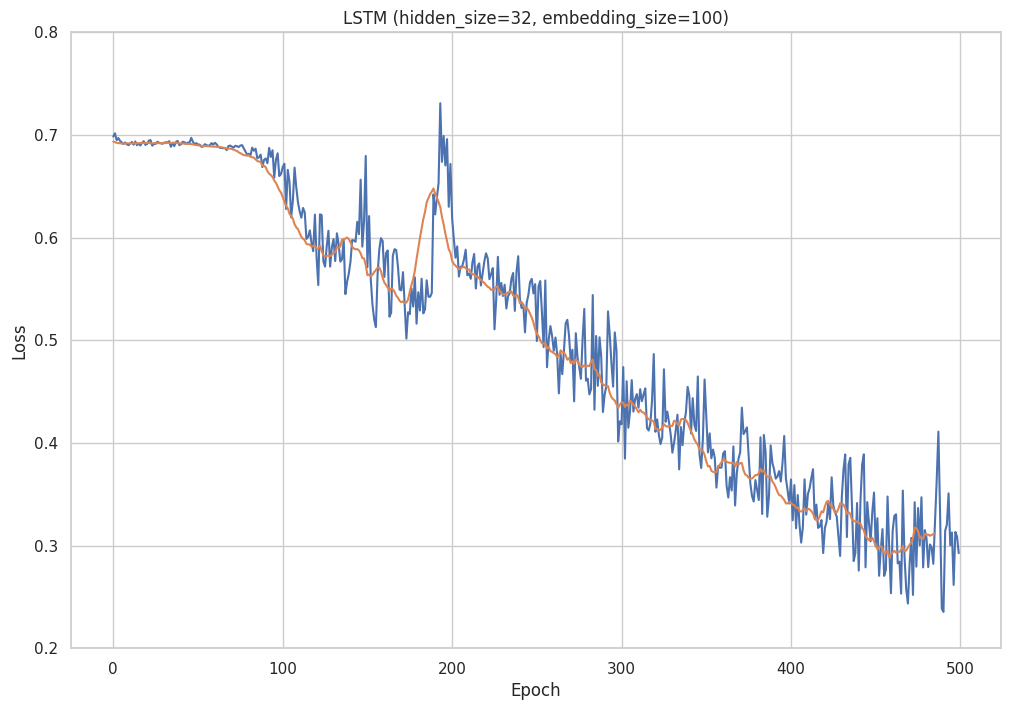

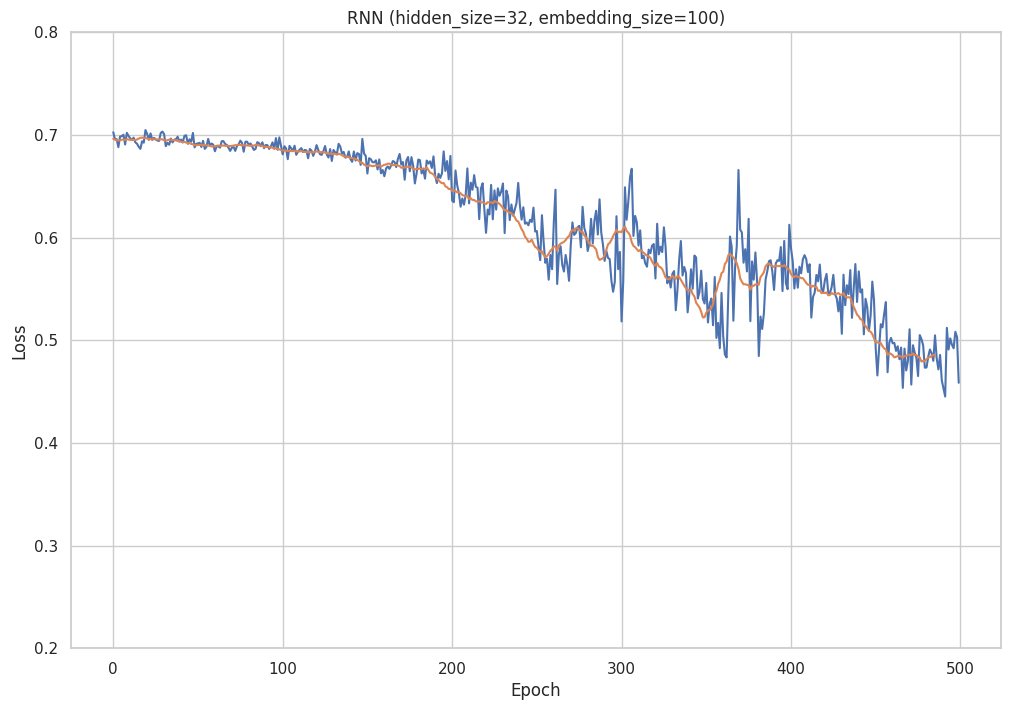

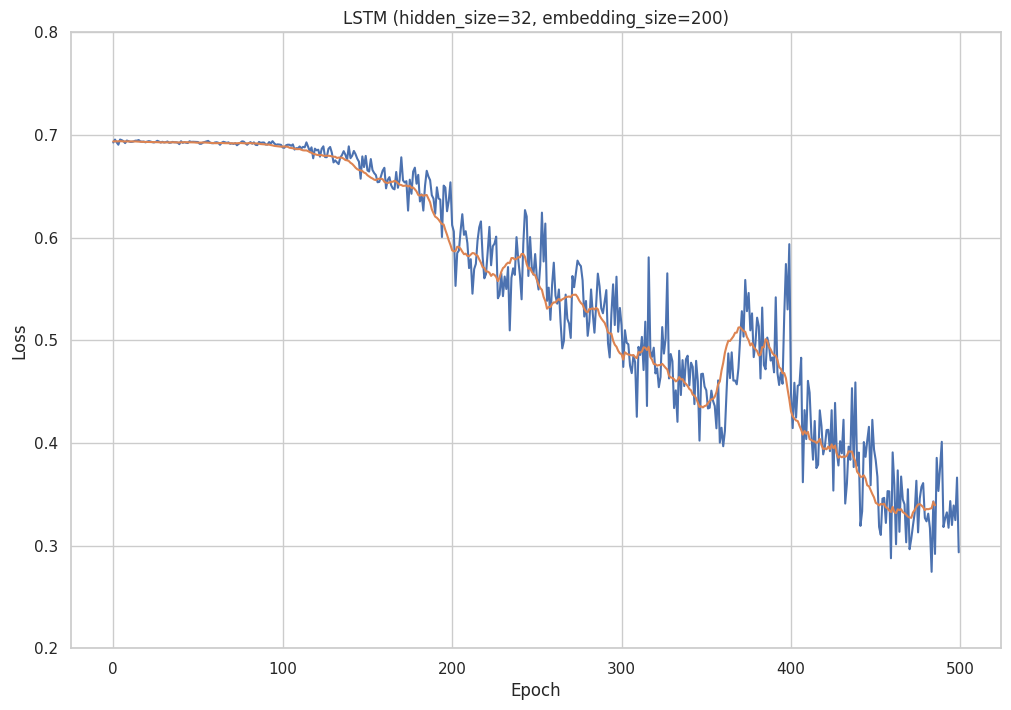

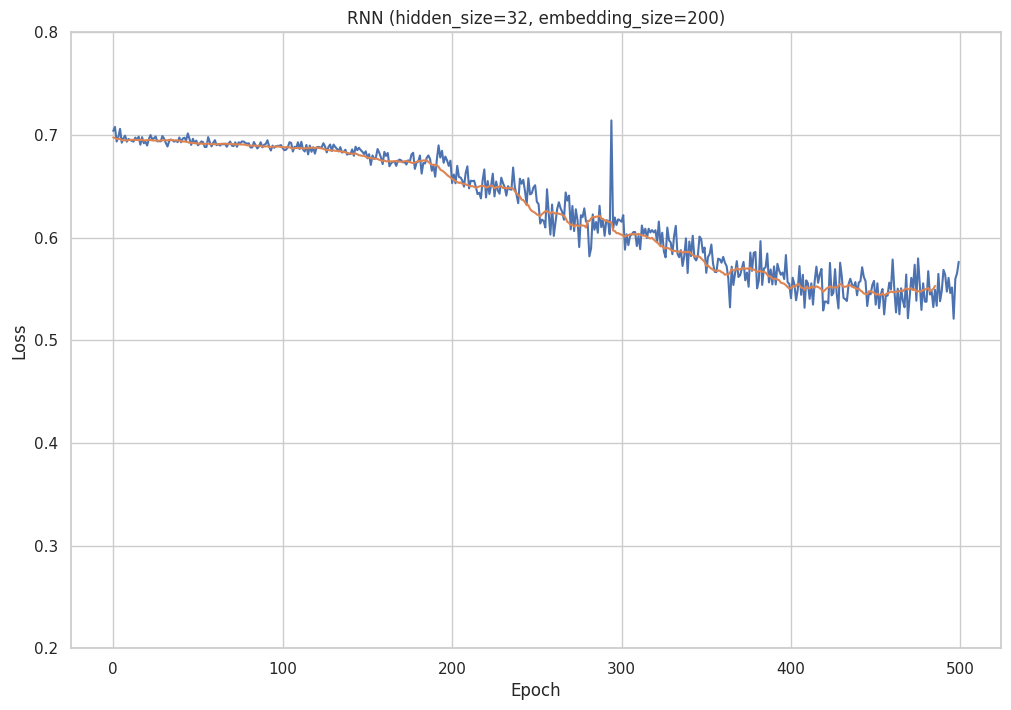

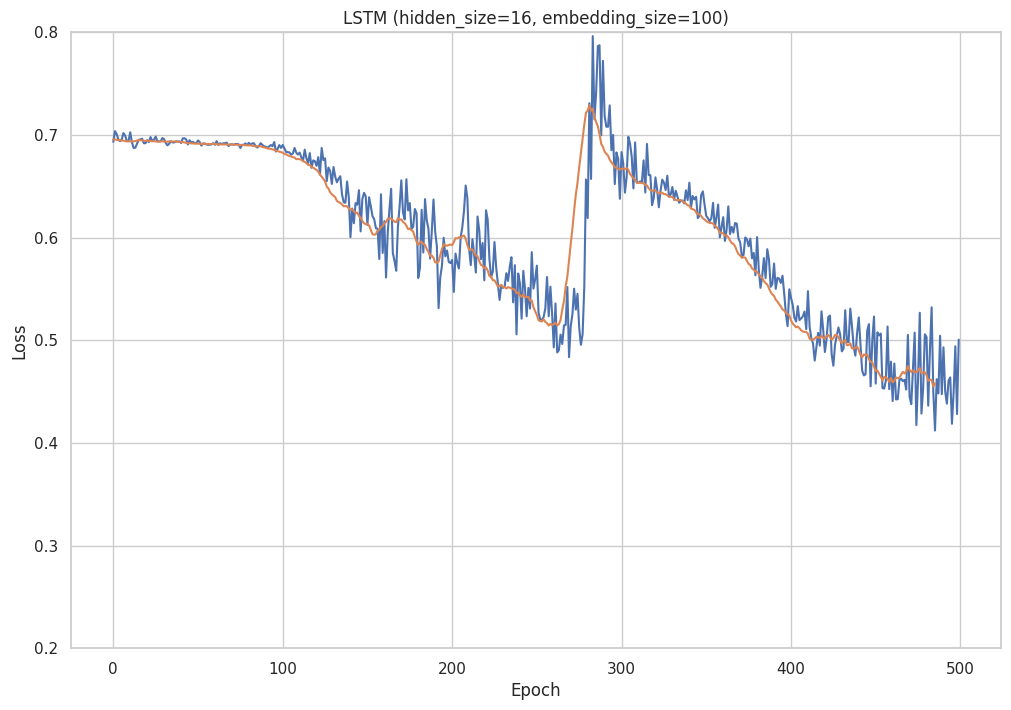

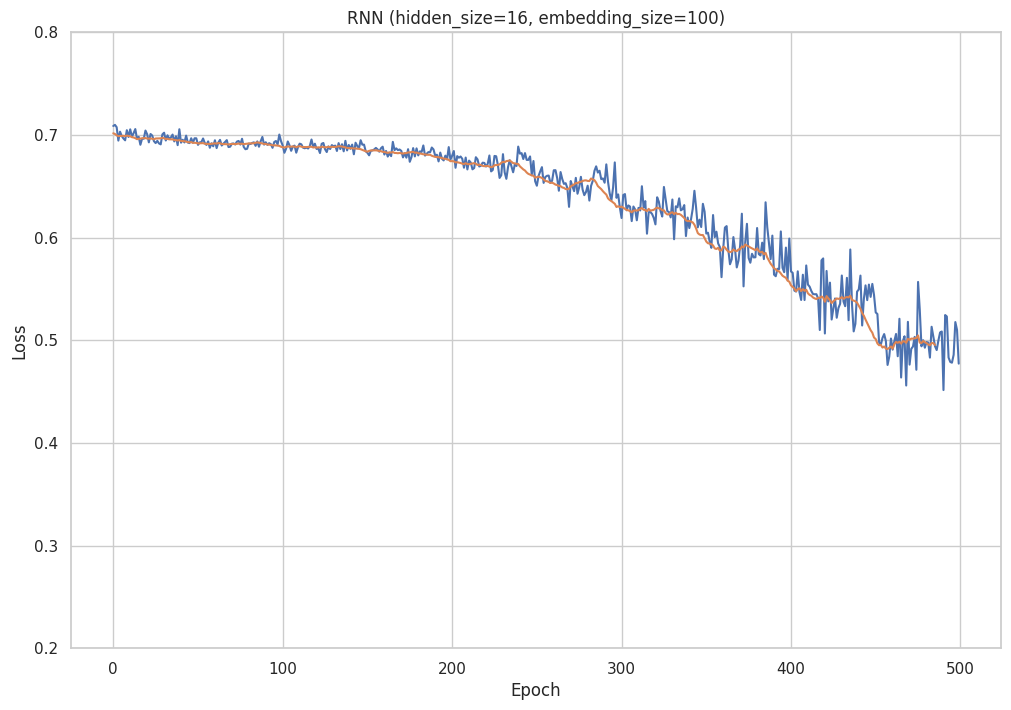

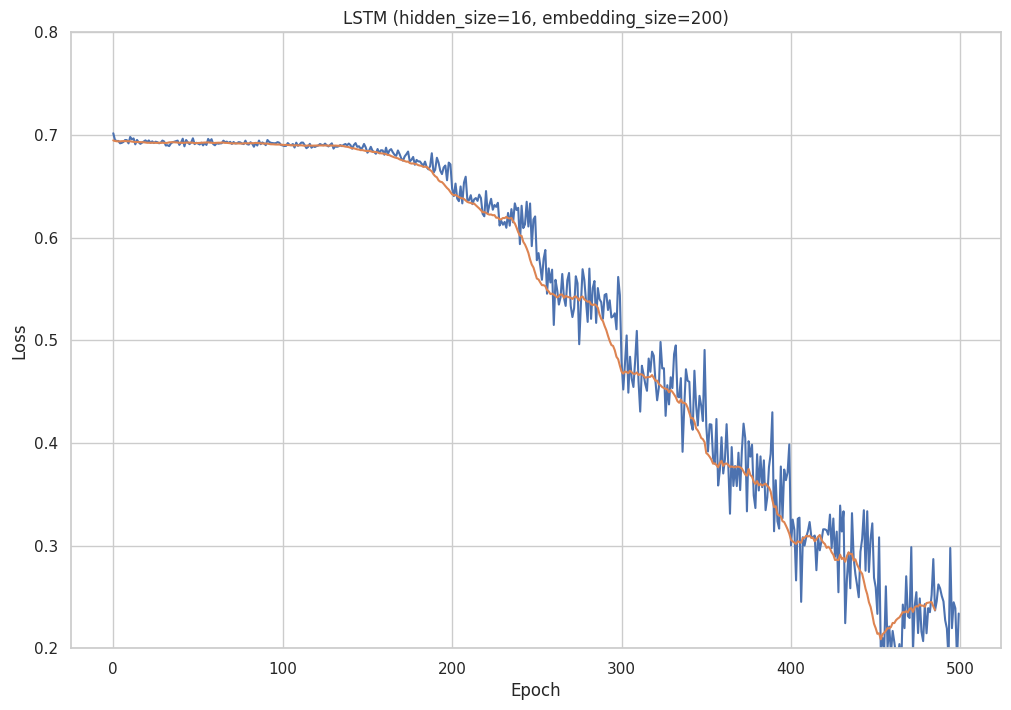

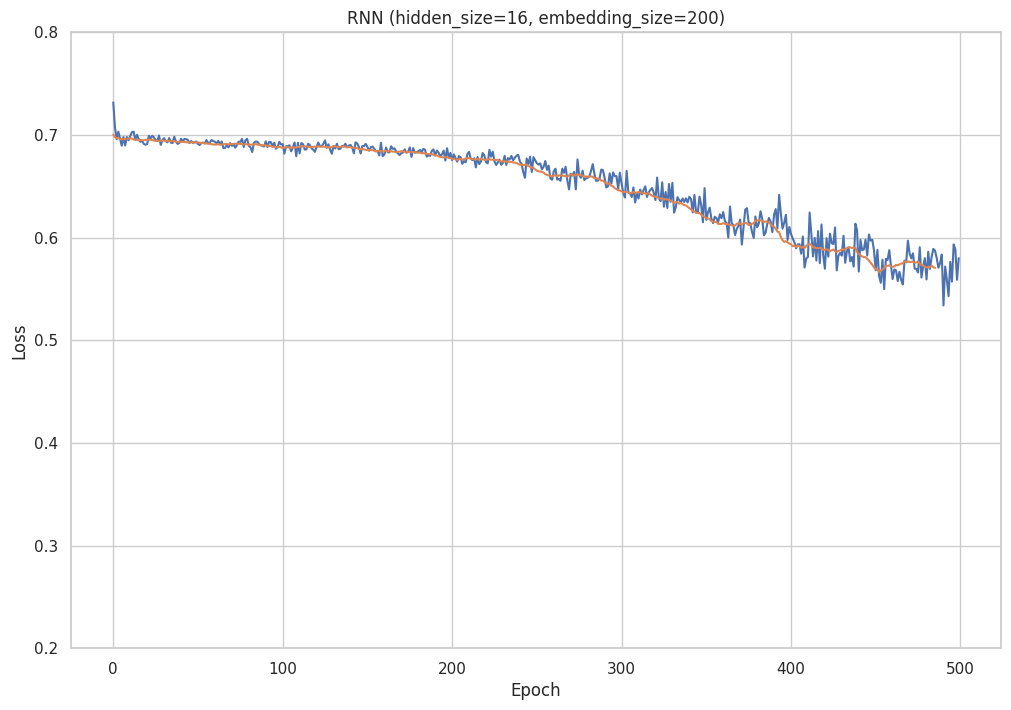

In [ ]:

for name, data in losses_over_epochs.items():
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(data)
    ax.plot(np.convolve(data, np.ones(15) / 15, mode='valid'))
    ax.set_title(name)
    ax.set_ylim([0.2, 0.8])  # Set y-axis limit
    ax.set(xlabel='Epoch', ylabel='Loss')
    plt.show()
